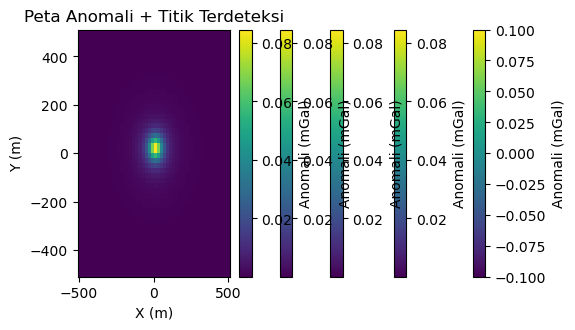

In [2]:
# ============================================================
# GUI Forward Modeling Gravitasi + Peta Anomali (Indonesia)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk, filedialog, messagebox

# --------------------------------------------
# Fungsi gravitasi (model bola 3D)
# --------------------------------------------
def gravity_sphere(x, y, x0, y0, z0, R, drho):
    G = 6.674e-11
    r2 = (x - x0)**2 + (y - y0)**2 + z0**2
    mass = (4/3) * np.pi * R**3 * drho
    gz = G * mass * z0 / (r2**1.5)
    return gz * 1e5  # ke mGal

# ==========================================================
# Kelas GUI
# ==========================================================
class GravityGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Forward Modeling Gravitasi – Peta Anomali")
        self.spheres = []
        self.X = None
        self.Y = None
        self.G = None

        frame = ttk.Frame(root)
        frame.pack(padx=10, pady=10)

        # ----------------------------
        # Input parameter bola
        # ----------------------------
        ttk.Label(frame, text="Parameter Bola (x0, y0, kedalaman, radius, Δρ)").grid(row=0, column=0, columnspan=3)
        self.e_x0 = ttk.Entry(frame, width=8)
        self.e_y0 = ttk.Entry(frame, width=8)
        self.e_z0 = ttk.Entry(frame, width=8)
        self.e_R  = ttk.Entry(frame, width=8)
        self.e_drho = ttk.Entry(frame, width=8)

        labels = ["x0 (m)", "y0 (m)", "z0 kedalaman (m)", "R (m)", "Δρ (kg/m³)"]
        entries = [self.e_x0, self.e_y0, self.e_z0, self.e_R, self.e_drho]

        for i, (lab, ent) in enumerate(zip(labels, entries)):
            ttk.Label(frame, text=lab).grid(row=i+1, column=0)
            ent.grid(row=i+1, column=1)

        ttk.Button(frame, text="Tambah Bola", command=self.add_sphere).grid(row=6, column=0, pady=5)
        ttk.Button(frame, text="Hapus Bola Terakhir", command=self.remove_sphere).grid(row=6, column=1)

        # ----------------------------
        # Grid perhitungan
        # ----------------------------
        ttk.Label(frame, text="Grid X").grid(row=7, column=0)
        self.ex1 = ttk.Entry(frame, width=8)
        self.ex2 = ttk.Entry(frame, width=8)
        self.nx  = ttk.Entry(frame, width=8)
        self.ex1.insert(0, "-500")
        self.ex2.insert(0, "500")
        self.nx.insert(0, "50")
        self.ex1.grid(row=7, column=1)
        self.ex2.grid(row=7, column=2)
        self.nx.grid(row=7, column=3)

        ttk.Label(frame, text="Grid Y").grid(row=8, column=0)
        self.ey1 = ttk.Entry(frame, width=8)
        self.ey2 = ttk.Entry(frame, width=8)
        self.ny  = ttk.Entry(frame, width=8)
        self.ey1.insert(0, "-500")
        self.ey2.insert(0, "500")
        self.ny.insert(0, "50")
        self.ey1.grid(row=8, column=1)
        self.ey2.grid(row=8, column=2)
        self.ny.grid(row=8, column=3)

        # Tombol hitung
        ttk.Button(frame, text="Hitung & Tampilkan Peta", command=self.compute_and_plot).grid(row=9, column=0, columnspan=2, pady=8)

        # Ambang deteksi
        ttk.Label(frame, text="Ambang Deteksi (mGal)").grid(row=10, column=0)
        self.e_thr = ttk.Entry(frame, width=8)
        self.e_thr.insert(0, "0.5")
        self.e_thr.grid(row=10, column=1)
        ttk.Button(frame, text="Deteksi & Tandai", command=self.detect_peaks).grid(row=10, column=2)

        # Simpan
        ttk.Button(frame, text="Simpan Gambar", command=self.save_image).grid(row=11, column=0, pady=8)
        ttk.Button(frame, text="Ekspor Grid Data", command=self.export_grid).grid(row=11, column=1)

        # Area plot
        self.fig, self.ax = plt.subplots(figsize=(6,5))
        self.canvas = FigureCanvasTkAgg(self.fig, master=root)
        self.canvas.get_tk_widget().pack()

    # =====================================================
    # Tambah bola
    # =====================================================
    def add_sphere(self):
        try:
            x0 = float(self.e_x0.get())
            y0 = float(self.e_y0.get())
            z0 = float(self.e_z0.get())
            R  = float(self.e_R.get())
            drho = float(self.e_drho.get())
            self.spheres.append((x0, y0, z0, R, drho))
            messagebox.showinfo("Info", f"Bola ditambahkan. Total = {len(self.spheres)}")
        except:
            messagebox.showerror("Error", "Input tidak valid")

    # Hapus bola terakhir
    def remove_sphere(self):
        if self.spheres:
            self.spheres.pop()
            messagebox.showinfo("Info", f"Bola terakhir dihapus. Sisa = {len(self.spheres)}")

    # =====================================================
    # Hitung peta gravitasi
    # =====================================================
    def compute_and_plot(self):
        x1, x2 = float(self.ex1.get()), float(self.ex2.get())
        y1, y2 = float(self.ey1.get()), float(self.ey2.get())
        nx, ny = int(self.nx.get()), int(self.ny.get())

        x = np.linspace(x1, x2, nx)
        y = np.linspace(y1, y2, ny)
        X, Y = np.meshgrid(x, y)

        Gmap = np.zeros_like(X)
        for (x0, y0, z0, R, drho) in self.spheres:
            Gmap += gravity_sphere(X, Y, x0, y0, z0, R, drho)

        self.X, self.Y, self.G = X, Y, Gmap

        self.ax.clear()
        c = self.ax.pcolormesh(X, Y, Gmap, shading="auto")
        self.fig.colorbar(c, ax=self.ax, label="Anomali (mGal)")
        self.ax.set_title("Peta Anomali Gravitasi")
        self.ax.set_xlabel("X (m)")
        self.ax.set_ylabel("Y (m)")
        self.canvas.draw()

    # =====================================================
    # Deteksi anomali
    # =====================================================
    def detect_peaks(self):
        if self.G is None:
            return
        thr = float(self.e_thr.get())

        mask = self.G >= thr
        Yidx, Xidx = np.where(mask)

        self.ax.scatter(self.X[Yidx, Xidx], self.Y[Yidx, Xidx], s=10, c="white", edgecolor="black")
        self.ax.set_title("Peta Anomali + Titik Terdeteksi")
        self.canvas.draw()

    # =====================================================
    # Simpan gambar
    # =====================================================
    def save_image(self):
        fname = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG", "*.png")])
        if fname:
            self.fig.savefig(fname, dpi=300)
            messagebox.showinfo("Info", "Gambar berhasil disimpan.")

    # =====================================================
    # Ekspor data grid
    # =====================================================
    def export_grid(self):
        if self.G is None:
            return

        fname = filedialog.asksaveasfilename(defaultextension=".txt", filetypes=[("Text", "*.txt"), ("CSV", "*.csv")])
        if not fname:
            return

        nx, ny = self.X.shape

        header = (
            f"# x_start={self.X[0,0]} "
            f"x_end={self.X[0,-1]} "
            f"y_start={self.Y[0,0]} "
            f"y_end={self.Y[-1,0]} "
            f"nx={nx} ny={ny}"
        )

        data = np.column_stack((self.X.ravel(), self.Y.ravel(), self.G.ravel()))
        np.savetxt(fname, data, header=header)
        messagebox.showinfo("Info", "Data berhasil diekspor.")

# ==========================================================
# MAIN
# ==========================================================
root = tk.Tk()
app = GravityGUI(root)
root.mainloop()
